In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from catalyst import dl, metrics
from catalyst.contrib.losses import DiceLoss, IoULoss
from catalyst.contrib.optimizers import AdamP, Lamb

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve

import datetime
import random

import sys
import os
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "datasets"))

from InriaImagesDataset import ImagesDataset
from SegmentationCustomRunner import SegmentationCustomRunner

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_DIR = os.path.join(os.path.abspath('..'), 'data', 'PreprocessedAerialImageDataset')

TRAIN_DIR = os.path.join(DATA_DIR, 'train')

today = datetime.datetime.now()

# Загрузка данных

In [3]:
df_all = pd.read_csv(os.path.join(TRAIN_DIR, 'labels.csv'))
df_all

,image,mask
0,images/austin10_image_0.jpg,gt/austin10_mask_0.png
1,images/austin10_image_1.jpg,gt/austin10_mask_1.png
2,images/austin10_image_10.jpg,gt/austin10_mask_10.png
3,images/austin10_image_11.jpg,gt/austin10_mask_11.png
4,images/austin10_image_12.jpg,gt/austin10_mask_12.png
...,...,...
17995,images/vienna9_image_95.jpg,gt/vienna9_mask_95.png
17996,images/vienna9_image_96.jpg,gt/vienna9_mask_96.png
17997,images/vienna9_image_97.jpg,gt/vienna9_mask_97.png
17998,images/vienna9_image_98.jpg,gt/vienna9_mask_98.png


In [4]:
X, y = df_all['image'], df_all['mask']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

In [5]:
df_train, df_valid = pd.concat([X_train, y_train], axis=1), pd.concat([X_valid, y_valid], axis=1)

In [6]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(),
        A.RGBShift(p=0.5),
        A.Blur(),
        A.GaussNoise(var_limit=1),
        A.ElasticTransform(),
        A.MaskDropout((1, 10), p=0.5),
        ToTensorV2()
    ],
    is_check_shapes=False
)

val_transform = A.Compose(
    [   
        A.Resize(256, 256),
        ToTensorV2()
    ],
    is_check_shapes=False
)

In [7]:
ds_train = ImagesDataset(df_train, TRAIN_DIR, transform=train_transform)
ds_val = ImagesDataset(df_valid, TRAIN_DIR, transform=val_transform)

In [8]:
ds_train[0]['image'].unique()

tensor([ 42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
        196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

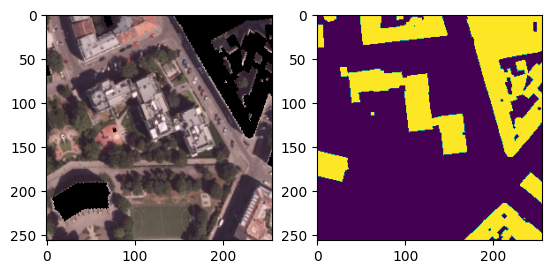

In [9]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ds_train[0]['image'].permute(1, 2, 0))
ax[1].imshow(ds_train[0]['mask'].squeeze())

In [10]:
loaders = {"train": DataLoader(ds_train, batch_size=8), 'valid': DataLoader(ds_val, batch_size=16)}

# Подготовка к обучению модели

In [11]:
#model = smp.Unet(encoder_name='efficientnet-b0', aux_params=aux_params).to(DEVICE)
#model = smp.Unet(encoder_name='efficientnet-b0').to(DEVICE)
#encoder_name = 'timm-mobilenetv3_small_075'
encoder_name = 'tu-maxvit_rmlp_pico_rw_256'
#encoder_name = 'vgg11'
model = smp.Unet(encoder_name=encoder_name, activation='sigmoid', classes=1).to(DEVICE)
model

f:\housing-segmentation-in-amur-river-area\env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Unet(
  (encoder): TimmUniversalEncoder(
    (model): FeatureListNet(
      (stem): Stem(
        (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm1): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (stages_0): MaxxVitStage(
        (blocks): Sequential(
          (0): MaxxVitBlock(
            (conv): MbConvBlock(
              (shortcut): Downsample2d(
                (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
                (expand): Identity()
              )
              (pre_norm): BatchNormAct2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): Identity()
              )
              (down): Identity(

In [12]:
criterion = IoULoss()
#criterion = DiceLoss()
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

In [13]:
optimizer = {
    "classification": torch.optim.Adam(model.parameters(), lr=1e-4),
    #"classification": Lamb(model.parameters(), lr=1e-3)
}

In [14]:
runner = SegmentationCustomRunner(input_key="image", output_key="mask_pred", target_key="mask_target", loss_key="loss")
#runner = CustomRunner()

# Обучение модели

In [15]:
EXP_NAME = f"{encoder_name}-{today.strftime('%d-%m-%Y')}-augmentations"

In [16]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    engine=dl.GPUEngine("cuda:0"),
    loaders=loaders,
    callbacks=[
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="mask_pred", target_key="mask_target"),
        dl.DiceCallback(input_key="mask_pred", target_key="mask_target"),
        dl.TrevskyCallback(input_key="mask_pred", target_key="mask_target", alpha=0.2),
        dl.PrecisionRecallF1SupportCallback(
            input_key="label_pred", target_key="label_target", num_classes=1
        ),
        dl.OptimizerCallback(
            optimizer_key="classification",
            metric_key="loss",
        ),
    ],
    valid_loader="valid",
    valid_metric="iou",
    minimize_valid_metric=False,
    num_epochs=15,
    verbose=True,
    logdir=f"./logs/{EXP_NAME}",
    load_best_on_end=True
)

1/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (1/15) dice: 0.6189103126525879 | dice/_macro: 0.6189103126525879 | dice/_micro: 0.6189103126525879 | f1/_macro: 0.9442005788097911 | f1/_micro: 0.9442005788097911 | f1/_weighted: 0.9442005788097911 | iou: 0.44813188910484314 | iou/_macro: 0.44813188910484314 | iou/_micro: 0.44813188910484314 | loss: 0.4985263266386808 | loss/mean: 0.4985263266386808 | loss/std: 0.15935853752383905 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9699598291740907 | precision/_micro: 0.9699598291740907 | precision/_weighted: 0.9699598291740907 | recall/_macro: 0.9197835945443485 | recall/_micro: 0.9197835945443485 | recall/_weighted: 0.9197835945443485 | trevsky: 0.5476278066635132 | trevsky/_macro: 0.5476278066635132 | trevsky/_micro: 0.5476278066635132


f:\housing-segmentation-in-amur-river-area\env\lib\site-packages\accelerate\utils\dataclasses.py:522: FutureWarning: The `TPU` of `<enum 'DistributedType'>` is deprecated and will be removed in v1.0.0. Please use the `XLA` instead.
  warnings.warn(


1/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (1/15) dice: 0.7700210809707642 | dice/_macro: 0.7700210809707642 | dice/_micro: 0.7700210809707642 | f1/_macro: 0.9526258290204819 | f1/_micro: 0.9526258290204819 | f1/_weighted: 0.9526258290204819 | iou: 0.6260440945625305 | iou/_macro: 0.6260440945625305 | iou/_micro: 0.6260440945625305 | loss: 0.37645940828323365 | loss/mean: 0.37645940828323365 | loss/std: 0.057256338845536756 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9717483093660395 | precision/_micro: 0.9717483093660395 | precision/_weighted: 0.9717483093660395 | recall/_macro: 0.9342510392669925 | recall/_micro: 0.9342510392669925 | recall/_weighted: 0.9342510392669925 | trevsky: 0.7276923656463623 | trevsky/_macro: 0.7276923656463623 | trevsky/_micro: 0.7276923656463623
* Epoch (1/15) 


2/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (2/15) dice: 0.7777469754219055 | dice/_macro: 0.7777469754219055 | dice/_micro: 0.7777469754219055 | f1/_macro: 0.9688956657376451 | f1/_micro: 0.9688956657376451 | f1/_weighted: 0.9688956657376451 | iou: 0.6363223791122437 | iou/_macro: 0.6363223791122437 | iou/_micro: 0.6363223791122437 | loss: 0.3720877037931372 | loss/mean: 0.3720877037931372 | loss/std: 0.09538814603137441 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.970609974804129 | precision/_micro: 0.970609974804129 | precision/_weighted: 0.970609974804129 | recall/_macro: 0.9671973664202401 | recall/_micro: 0.9671973664202401 | recall/_weighted: 0.9671973664202401 | trevsky: 0.7710787057876587 | trevsky/_macro: 0.7710787057876587 | trevsky/_micro: 0.7710787057876587


2/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (2/15) dice: 0.8255447149276733 | dice/_macro: 0.8255447149276733 | dice/_micro: 0.8255447149276733 | f1/_macro: 0.9667997584084076 | f1/_micro: 0.9667997584084076 | f1/_weighted: 0.9667997584084076 | iou: 0.7029170989990234 | iou/_macro: 0.7029170989990234 | iou/_micro: 0.7029170989990234 | loss: 0.2992089271015591 | loss/mean: 0.2992089271015591 | loss/std: 0.049008393021311 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9720153083488591 | precision/_micro: 0.9720153083488591 | precision/_weighted: 0.9720153083488591 | recall/_macro: 0.9616497732415233 | recall/_micro: 0.9616497732415233 | recall/_weighted: 0.9616497732415233 | trevsky: 0.8115389943122864 | trevsky/_macro: 0.8115389943122864 | trevsky/_micro: 0.8115389943122864
* Epoch (2/15) 


3/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (3/15) dice: 0.7919893860816956 | dice/_macro: 0.7919893860816956 | dice/_micro: 0.7919893860816956 | f1/_macro: 0.9709374119792022 | f1/_micro: 0.9709374119792022 | f1/_weighted: 0.9709374119792022 | iou: 0.6556145548820496 | iou/_macro: 0.6556145548820496 | iou/_micro: 0.6556145548820496 | loss: 0.35366086458276796 | loss/mean: 0.35366086458276796 | loss/std: 0.09315182944153147 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9718967234121684 | precision/_micro: 0.9718967234121684 | precision/_weighted: 0.9718967234121684 | recall/_macro: 0.9699899727354985 | recall/_micro: 0.9699899727354985 | recall/_weighted: 0.9699899727354985 | trevsky: 0.7884377241134644 | trevsky/_macro: 0.7884377241134644 | trevsky/_micro: 0.7884377241134644


3/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (3/15) dice: 0.7952049374580383 | dice/_macro: 0.7952049374580383 | dice/_micro: 0.7952049374580383 | f1/_macro: 0.9565967291533636 | f1/_micro: 0.9565967291533636 | f1/_weighted: 0.9565967291533636 | iou: 0.6600332856178284 | iou/_macro: 0.6600332856178284 | iou/_micro: 0.6600332856178284 | loss: 0.3405116988817852 | loss/mean: 0.3405116988817852 | loss/std: 0.0549797525359602 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.979273473500789 | precision/_micro: 0.979273473500789 | precision/_weighted: 0.979273473500789 | recall/_macro: 0.9349559997867202 | recall/_micro: 0.9349559997867202 | recall/_weighted: 0.9349559997867202 | trevsky: 0.7464115619659424 | trevsky/_macro: 0.7464115619659424 | trevsky/_micro: 0.7464115619659424
* Epoch (3/15) 


4/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (4/15) dice: 0.7986183166503906 | dice/_macro: 0.7986183166503906 | dice/_micro: 0.7986183166503906 | f1/_macro: 0.9718127656685456 | f1/_micro: 0.9718127656685456 | f1/_weighted: 0.9718127656685456 | iou: 0.664749801158905 | iou/_macro: 0.664749801158905 | iou/_micro: 0.664749801158905 | loss: 0.3420142858116717 | loss/mean: 0.3420142858116717 | loss/std: 0.0882244065187955 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9729772645012825 | precision/_micro: 0.9729772645012825 | precision/_weighted: 0.9729772645012825 | recall/_macro: 0.9706610270347731 | recall/_micro: 0.9706610270347731 | recall/_weighted: 0.9706610270347731 | trevsky: 0.7944758534431458 | trevsky/_macro: 0.7944758534431458 | trevsky/_micro: 0.7944758534431458


4/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (4/15) dice: 0.8318763971328735 | dice/_macro: 0.8318763971328735 | dice/_micro: 0.8318763971328735 | f1/_macro: 0.9673966325173898 | f1/_micro: 0.9673966325173898 | f1/_weighted: 0.9673966325173898 | iou: 0.7121475338935852 | iou/_macro: 0.7121475338935852 | iou/_micro: 0.7121475338935852 | loss: 0.2903008480072021 | loss/mean: 0.2903008480072021 | loss/std: 0.04871420810621136 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9750741743882282 | precision/_micro: 0.9750741743882282 | precision/_weighted: 0.9750741743882282 | recall/_macro: 0.9598488927751783 | recall/_micro: 0.9598488927751783 | recall/_weighted: 0.9598488927751783 | trevsky: 0.8120632767677307 | trevsky/_macro: 0.8120632767677307 | trevsky/_micro: 0.8120632767677307
* Epoch (4/15) 


5/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (5/15) dice: 0.807487964630127 | dice/_macro: 0.807487964630127 | dice/_micro: 0.807487964630127 | f1/_macro: 0.9730018594332394 | f1/_micro: 0.9730018594332394 | f1/_weighted: 0.9730018594332394 | iou: 0.6771318316459656 | iou/_macro: 0.6771318316459656 | iou/_micro: 0.6771318316459656 | loss: 0.3300577520970944 | loss/mean: 0.3300577520970944 | loss/std: 0.082829472860268 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9741457296903419 | precision/_micro: 0.9741457296903419 | precision/_weighted: 0.9741457296903419 | recall/_macro: 0.9718706488999002 | recall/_micro: 0.9718706488999002 | recall/_weighted: 0.9718706488999002 | trevsky: 0.8034246563911438 | trevsky/_macro: 0.8034246563911438 | trevsky/_micro: 0.8034246563911438


5/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (5/15) dice: 0.8425288796424866 | dice/_macro: 0.8425288796424866 | dice/_micro: 0.8425288796424866 | f1/_macro: 0.9699797451381237 | f1/_micro: 0.9699797451381237 | f1/_weighted: 0.9699797451381237 | iou: 0.7279048562049866 | iou/_macro: 0.7279048562049866 | iou/_micro: 0.7279048562049866 | loss: 0.27429289473427676 | loss/mean: 0.27429289473427676 | loss/std: 0.04417397288426511 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.974862098983793 | precision/_micro: 0.974862098983793 | precision/_weighted: 0.974862098983793 | recall/_macro: 0.9651559520277916 | recall/_micro: 0.9651559520277916 | recall/_weighted: 0.9651559520277916 | trevsky: 0.8294504880905151 | trevsky/_macro: 0.8294504880905151 | trevsky/_micro: 0.8294504880905151
* Epoch (5/15) 


6/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (6/15) dice: 0.8090032935142517 | dice/_macro: 0.8090032935142517 | dice/_micro: 0.8090032935142517 | f1/_macro: 0.973135451643179 | f1/_micro: 0.973135451643179 | f1/_weighted: 0.973135451643179 | iou: 0.6792657375335693 | iou/_macro: 0.6792657375335693 | iou/_micro: 0.6792657375335693 | loss: 0.32812810774202744 | loss/mean: 0.32812810774202744 | loss/std: 0.08745347585946221 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9744099231138195 | precision/_micro: 0.9744099231138195 | precision/_weighted: 0.9744099231138195 | recall/_macro: 0.971874283562085 | recall/_micro: 0.971874283562085 | recall/_weighted: 0.971874283562085 | trevsky: 0.8045117259025574 | trevsky/_macro: 0.8045117259025574 | trevsky/_micro: 0.8045117259025574


6/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (6/15) dice: 0.8173965811729431 | dice/_macro: 0.8173965811729431 | dice/_micro: 0.8173965811729431 | f1/_macro: 0.9683326897079045 | f1/_micro: 0.9683326897079045 | f1/_weighted: 0.9683326897079045 | iou: 0.6911839842796326 | iou/_macro: 0.6911839842796326 | iou/_micro: 0.6911839842796326 | loss: 0.3115169610977172 | loss/mean: 0.3115169610977172 | loss/std: 0.06586366765880099 | lr/classification: 0.0001 | momentum/classification: 0.9 | precision/_macro: 0.9591374563583925 | precision/_micro: 0.9591374563583925 | precision/_weighted: 0.9591374563583925 | recall/_macro: 0.9777161323561196 | recall/_micro: 0.9777161323561196 | recall/_weighted: 0.9777161323561196 | trevsky: 0.8453876972198486 | trevsky/_macro: 0.8453876972198486 | trevsky/_micro: 0.8453876972198486
* Epoch (6/15) 


7/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: 

In [18]:
print("Best model metrics:")
print("-"*50)
metrics = runner.evaluate_loader(
    loader=loaders["valid"],
    callbacks=[
        dl.IOUCallback(input_key="mask_pred", target_key="mask_target"),
        dl.DiceCallback(input_key="mask_pred", target_key="mask_target"),
    ]
)

Best model metrics:
--------------------------------------------------
valid (1/1) dice: 0.8488470911979675 | dice/_macro: 0.8488470911979675 | dice/_micro: 0.8488470911979675 | iou: 0.7373886704444885 | iou/_macro: 0.7373886704444885 | iou/_micro: 0.7373886704444885
* Epoch (1/1) 


# Тестирование модели

In [19]:
def inference_one_image(image, model, transform):
    image_tensor = image.astype(np.float32)
    #image_tensor = torch.tensor(image_tensor, device=DEVICE).permute(2, 0, 1).unsqueeze(0)
    if transform:
        augmented = transform(image=image_tensor)
        image_tensor = augmented['image'].to(DEVICE).unsqueeze(0)
    else:
        image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    model.eval()
    result_mask = model(image_tensor)
    result_mask = result_mask.squeeze().detach().cpu().numpy()
    #result_mask = (result_mask > 0.5).astype(np.int_)
    #result_label = result_label.squeeze().detach().cpu().numpy()
    return result_mask

In [50]:
test_image = cv2.imread(r'..\data\PreprocessedAerialImageDataset\train\images\austin1_image_0.png')
#test_image = cv2.resize(test_image, (512, 512))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

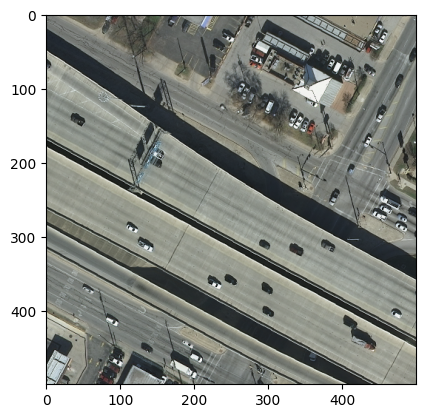

In [51]:
plt.imshow(test_image)

In [52]:
test_result = inference_one_image(test_image, model, val_transform)
test_result

array([[1.6495481e-08, 9.0122569e-15, 6.8798634e-18, ..., 2.7914246e-19,
        7.4790296e-17, 8.8910691e-11],
       [8.2894100e-15, 3.9369912e-26, 1.2288861e-30, ..., 9.0468308e-32,
        4.8272688e-28, 4.9664317e-18],
       [2.1208697e-17, 2.3450937e-30, 3.4450548e-35, ..., 2.3887057e-35,
        1.6343244e-31, 2.9193220e-20],
       ...,
       [9.9936861e-01, 9.9999988e-01, 1.0000000e+00, ..., 1.1499573e-30,
        8.8761653e-28, 8.5176607e-18],
       [9.9948692e-01, 9.9999988e-01, 1.0000000e+00, ..., 1.2154482e-25,
        2.1043745e-23, 3.7719885e-15],
       [9.9163169e-01, 9.9997354e-01, 9.9999988e-01, ..., 1.2391097e-16,
        2.0823274e-15, 3.6661341e-10]], dtype=float32)

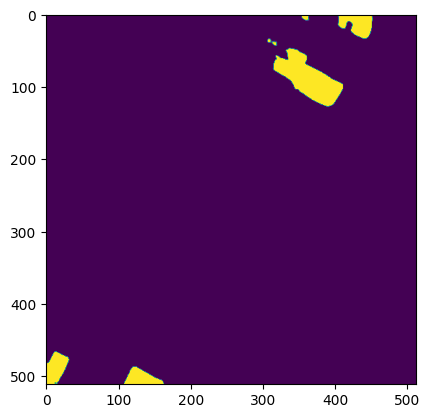

In [53]:
plt.imshow(test_result)

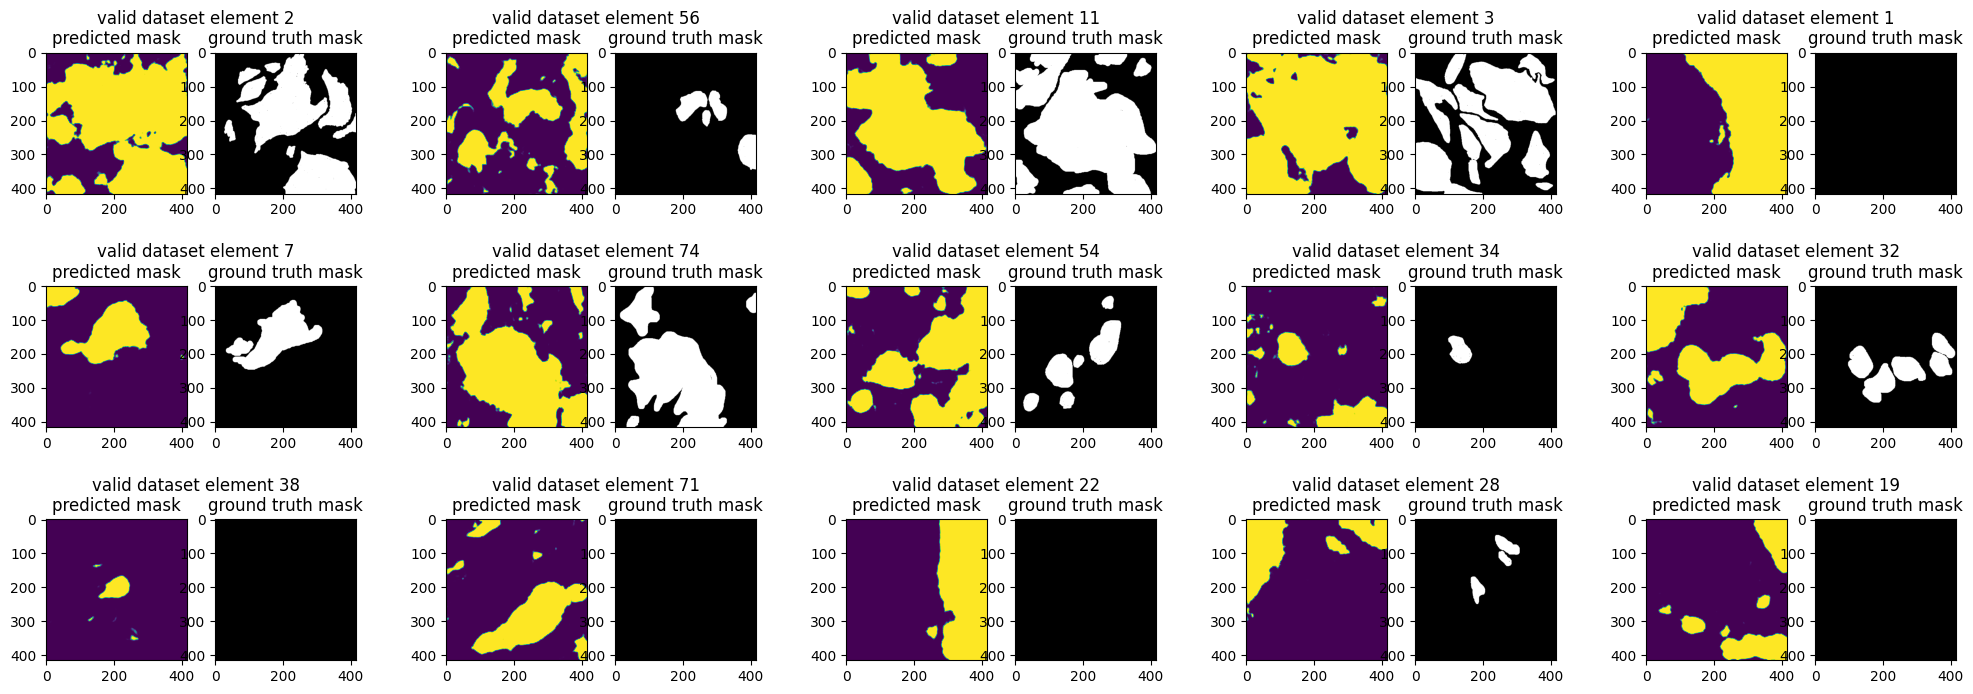

In [24]:
num_images = 15
valid_subset_numbers = random.sample(range(0, len(ds_val)), num_images)

fig = plt.figure(figsize=(20, 7))
subfigs = fig.subfigures(num_images // 5, 5)

i = 0
for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(1, 2)
    image, mask = ds_val[valid_subset_numbers[i]]['image'], ds_val[valid_subset_numbers[i]]['mask']
    subfig.suptitle(f'valid dataset element {valid_subset_numbers[i]}')

    mask_pred = model(image.to(DEVICE).unsqueeze(0)).detach().cpu().squeeze()
    axs[0].imshow(mask_pred)
    axs[0].set_title(f'predicted mask')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'ground truth mask')
    i += 1
plt.show()